# Классификация знаков Дорожного Движения

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [2]:
data = []
labels = []
sumu =0
input_size = (60,30)
for root, dirs, files in os.walk("./traffic_light_data/train"):  
    for dirs in natsorted(dirs):
        path = pathlib.Path('./traffic_light_data/train/' + dirs)
        count = 0
        for file_number in os.listdir(path):
#             if count == 1500: break
            count = count+1
            imagepath = ("./traffic_light_data/train/"+ dirs+"/"+str(file_number))
#             print(imagepath)
            image = cv2.imread(imagepath, 1) ## Считываем изображение
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
            image = transform.resize(image, input_size)
            data.append(image)

            label = dirs
            labels.append(label)
        sumu = sumu + count
        print (dirs, '(', count, ')')
print ('ready', sumu)

green ( 559 )
red ( 564 )
yellow ( 503 )
ready 1626


In [3]:
len(data)

1626

In [4]:
len(labels)

1626

In [5]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    3
dtype: int64
red       564
green     559
yellow    503
Name: labels, dtype: int64


## Обучение модели

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

num_classes = 3

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)#stratify = labels


from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

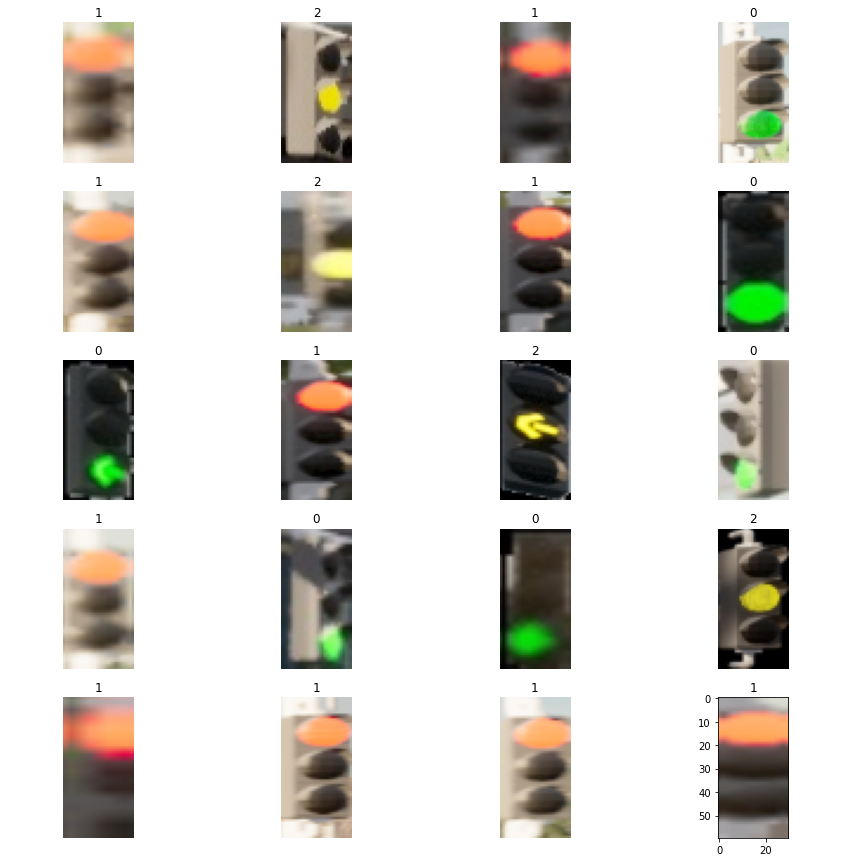

In [7]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [8]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import tensorflow_addons as tfa
import math
from keras.optimizers import SGD

opt = SGD(learning_rate=0.0003)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=8, kernel_size=5, activation='swish'))

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=16, kernel_size=5, activation='swish'))

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=32, kernel_size=5, activation='swish'))

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=64, kernel_size=5, activation='swish'))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(7, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов



model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics= tfa.metrics.F1Score(num_classes=num_classes)) #categorical_crossentropy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 64, 34, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 60, 30, 8)         608       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 64, 34, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 30, 16)        3216      
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 64, 34, 16)       0         
 ng2D)                                                           
                                                        

In [9]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.000001, end_lr=10, batch_size=5, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [10]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=5, epochs=250, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/250
228/228 [==============================] - 5s 14ms/step - loss: 1.0218 - f1_score: 0.4603 - val_loss: 0.8559 - val_f1_score: 0.5931
Epoch 2/250
228/228 [==============================] - 2s 11ms/step - loss: 0.6144 - f1_score: 0.8520 - val_loss: 0.2841 - val_f1_score: 0.9749
Epoch 3/250
228/228 [==============================] - 3s 11ms/step - loss: 0.1807 - f1_score: 0.9758 - val_loss: 0.1061 - val_f1_score: 0.9791
Epoch 4/250
228/228 [==============================] - 3s 11ms/step - loss: 0.0912 - f1_score: 0.9856 - val_loss: 0.0695 - val_f1_score: 0.9812
Epoch 5/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0616 - f1_score: 0.9875 - val_loss: 0.0561 - val_f1_score: 0.9791
Epoch 6/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0530 - f1_score: 0.9919 - val_loss: 0.0447 - val_f1_score: 0.9791
Epoch 7/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0396 - f1_score: 0.9938 - val_loss: 0.0411 - val_f1_score:

228/228 [==============================] - 3s 12ms/step - loss: 0.0032 - f1_score: 1.0000 - val_loss: 0.0137 - val_f1_score: 0.9895
Epoch 58/250
228/228 [==============================] - 3s 13ms/step - loss: 0.0027 - f1_score: 1.0000 - val_loss: 0.0153 - val_f1_score: 0.9895
Epoch 59/250
228/228 [==============================] - 3s 13ms/step - loss: 0.0035 - f1_score: 1.0000 - val_loss: 0.0145 - val_f1_score: 0.9895
Epoch 60/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0030 - f1_score: 1.0000 - val_loss: 0.0151 - val_f1_score: 0.9895
Epoch 61/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0036 - f1_score: 1.0000 - val_loss: 0.0145 - val_f1_score: 0.9895
Epoch 62/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0025 - f1_score: 1.0000 - val_loss: 0.0138 - val_f1_score: 0.9895
Epoch 63/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0029 - f1_score: 1.0000 - val_loss: 0.0137 - val_f1_score: 0.989

228/228 [==============================] - 3s 12ms/step - loss: 9.6140e-04 - f1_score: 1.0000 - val_loss: 0.0175 - val_f1_score: 0.9895
Epoch 114/250
228/228 [==============================] - 3s 12ms/step - loss: 8.3166e-04 - f1_score: 1.0000 - val_loss: 0.0145 - val_f1_score: 0.9895
Epoch 115/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0012 - f1_score: 1.0000 - val_loss: 0.0127 - val_f1_score: 0.9895
Epoch 116/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0010 - f1_score: 1.0000 - val_loss: 0.0128 - val_f1_score: 0.9895
Epoch 117/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0011 - f1_score: 1.0000 - val_loss: 0.0151 - val_f1_score: 0.9895
Epoch 118/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0015 - f1_score: 1.0000 - val_loss: 0.0156 - val_f1_score: 0.9895
Epoch 119/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0019 - f1_score: 1.0000 - val_loss: 0.0156 - val_f

228/228 [==============================] - 3s 12ms/step - loss: 7.1739e-04 - f1_score: 1.0000 - val_loss: 0.0130 - val_f1_score: 0.9916
Epoch 169/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0012 - f1_score: 1.0000 - val_loss: 0.0131 - val_f1_score: 0.9895
Epoch 170/250
228/228 [==============================] - 3s 12ms/step - loss: 5.9448e-04 - f1_score: 1.0000 - val_loss: 0.0137 - val_f1_score: 0.9895
Epoch 171/250
228/228 [==============================] - 3s 12ms/step - loss: 8.7770e-04 - f1_score: 1.0000 - val_loss: 0.0144 - val_f1_score: 0.9895
Epoch 172/250
228/228 [==============================] - 3s 12ms/step - loss: 6.1783e-04 - f1_score: 1.0000 - val_loss: 0.0138 - val_f1_score: 0.9895
Epoch 173/250
228/228 [==============================] - 3s 12ms/step - loss: 0.0011 - f1_score: 1.0000 - val_loss: 0.0120 - val_f1_score: 0.9937
Epoch 174/250
228/228 [==============================] - 3s 12ms/step - loss: 6.2583e-04 - f1_score: 1.0000 - val_loss: 0.

Epoch 223/250
228/228 [==============================] - 3s 14ms/step - loss: 5.3578e-04 - f1_score: 1.0000 - val_loss: 0.0175 - val_f1_score: 0.9895
Epoch 224/250
228/228 [==============================] - 3s 14ms/step - loss: 5.5360e-04 - f1_score: 1.0000 - val_loss: 0.0142 - val_f1_score: 0.9895
Epoch 225/250
228/228 [==============================] - 3s 13ms/step - loss: 4.8652e-04 - f1_score: 1.0000 - val_loss: 0.0121 - val_f1_score: 0.9916
Epoch 226/250
228/228 [==============================] - 3s 12ms/step - loss: 5.9062e-04 - f1_score: 1.0000 - val_loss: 0.0156 - val_f1_score: 0.9895
Epoch 227/250
228/228 [==============================] - 3s 12ms/step - loss: 3.4317e-04 - f1_score: 1.0000 - val_loss: 0.0136 - val_f1_score: 0.9916
Epoch 228/250
228/228 [==============================] - 3s 12ms/step - loss: 6.4727e-04 - f1_score: 1.0000 - val_loss: 0.0154 - val_f1_score: 0.9895
Epoch 229/250
228/228 [==============================] - 3s 12ms/step - loss: 5.5975e-04 - f1_score:

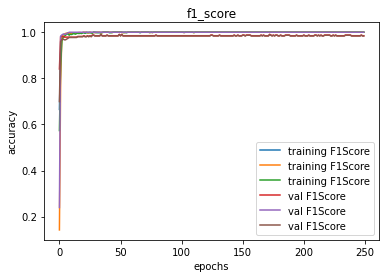

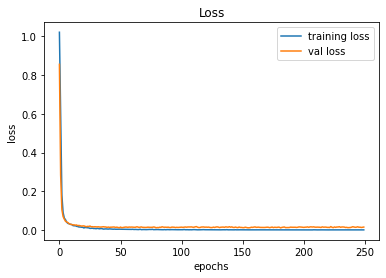

In [11]:
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
# model.save('./saved_models/Trafic_Lights_CNN(60x30).h5')

In [13]:
for root, dirs, files in os.walk("./IMG"): 
    for file in files:
        path_img = pathlib.Path('./IMG/' + file)
        image = cv2.imread(str(path_img)) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        image = np.array(image)
        img_batch = np.expand_dims(image, 0) 
        test_pred = model.predict(img_batch)
        prediction = np.argmax(test_pred, axis=1)
        
        print(file)
        if prediction[0] == 2:
            print('yellow' )
        if prediction[0] == 1:
            print('red' )
        if prediction[0] == 0:
            print('green' )

1/1 [==============================] - 0s 173ms/step
GreenLight.jpeg
green
1/1 [==============================] - 0s 16ms/step
GreenLight2.jpg
green
1/1 [==============================] - 0s 16ms/step
GreenLight3.jpeg
green
1/1 [==============================] - 0s 16ms/step
GreenLight4.jpeg
green
1/1 [==============================] - 0s 15ms/step
GreenLight5.jpg
green
1/1 [==============================] - 0s 15ms/step
RedLight.jpeg
red
1/1 [==============================] - 0s 16ms/step
RedLight2.jpeg
red
1/1 [==============================] - 0s 16ms/step
RedLight3.jpeg
red
1/1 [==============================] - 0s 15ms/step
RedLight4.jpeg
yellow
1/1 [==============================] - 0s 15ms/step
RedLight5.jpeg
red
1/1 [==============================] - 0s 19ms/step
YellowLight.png
yellow
1/1 [==============================] - 0s 16ms/step
YellowLight2.jpeg
yellow
1/1 [==============================] - 0s 16ms/step
YellowLight3.jpeg
yellow
1/1 [==============================] - 0s

In [14]:
count = 0 
ver = 0
for root, dirs, files in os.walk("./traffic_light_data/val"):  
    for dirs in natsorted(dirs):
        path = pathlib.Path('./traffic_light_data/val/' + dirs)
        for file_number in os.listdir(path):
            imagepath = ("./traffic_light_data/val/"+ dirs+"/"+str(file_number))
            image = cv2.imread(str(imagepath)) ## Считываем изображение
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
            image = transform.resize(image, input_size)
            image = np.array(image)
            img_batch = np.expand_dims(image, 0) 
            test_pred = model.predict(img_batch)
            prediction = np.argmax(test_pred, axis=1)

            if prediction[0] == 2:
                p = 'yellow'
            if prediction[0] == 1:
                p = 'red' 
            if prediction[0] == 0:
                p = 'green'
            count = count+1
            if dirs != p:
                ver = ver+1
                print(dirs, p, dirs == p, file_number)
                
test_accuracy = ver/count

1/1 [==============================] - 0s 28ms/step
red green False red_24.jpg
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


In [15]:
print(ver,count ,(1-test_accuracy)*100)

1 283 99.64664310954063


In [16]:
# 137 283 0.4840989399293286
# 3 283 0.01060070671378092
# 1 283 0.0035335689045936395
# 0 283 100.0
